##### 最低限の処理でLightGBM構築

In [1]:
import os
os.chdir('/Users/kinoshitashouhei/Desktop/competitions/05_Prob_Space/accommodation_charge_prediction/')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import warnings
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

from src.config import *
import src.preprocessing as pr

warnings.filterwarnings('ignore')

In [5]:
df_train = pd.read_csv('input/train_data.csv', parse_dates=[COL_LAST_REVIEW], dtype=DICT_DTYPES)
df_test = pd.read_csv('input/test_data.csv', parse_dates=[COL_LAST_REVIEW], dtype=DICT_DTYPES)
df_station_list = pd.read_csv('input/station_list.csv')
sample_sub = pd.read_csv('input/submission.csv')

In [6]:
LIST_USE_COL = [COL_NEIGHBOURHOOD,
                COL_LATITUDE,
                COL_LONGITUDE,
                COL_ROOM_TYPE,
                COL_MINIMUM_NIGHTS,
                COL_NUMBER_OF_REVIEWS,
                COL_REVIEWS_PER_MONTH,
                COL_AVAILABILITY_365]

In [7]:
LIST_LABEL_ENC = [COL_NEIGHBOURHOOD,
                  COL_ROOM_TYPE]

In [8]:
df_all = pd.concat([
    df_train[LIST_USE_COL],
    df_test[LIST_USE_COL]
]).reset_index(drop=True)

In [9]:
df_all.fillna(0, inplace=True)

In [10]:
for col in LIST_LABEL_ENC:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col])

In [12]:
df_all[:df_train.shape[0]].head()

,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,9,35.68185,139.80310,0,1,55,2.21,173
1,21,35.72063,139.78536,0,6,72,2.11,9
2,7,35.74723,139.82349,0,1,18,3.46,288
3,16,35.68456,139.68077,0,1,2,1.76,87
4,18,35.69840,139.70467,0,1,86,2.00,156


In [13]:
X = df_all[:df_train.shape[0]].reset_index(drop=True)
X_inference = df_all[df_train.shape[0]:].reset_index(drop=True)
y = np.log(df_train[COL_Y])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [15]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [16]:
params = {'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 多クラス分類を指定
          'metric': {'mean_squared_error'},  # 多クラス分類の損失（誤差）
          'learning_rate': 0.1}         # 学習率      

In [17]:
lgb_results = {}                                    # 学習の履歴を入れる入物
model = lgb.train(params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=30,         # アーリーストッピング設定
                  evals_result=lgb_results)         # 履歴を保存する

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number of data points in the train set: 7492, number of used features: 8
[LightGBM] [Info] Start training from score 9.454065
[1]	Train's l2: 0.894738	Test's l2: 0.906468
Training until validation scores don't improve for 30 rounds
[2]	Train's l2: 0.844899	Test's l2: 0.862998
[3]	Train's l2: 0.803344	Test's l2: 0.825307
[4]	Train's l2: 0.767475	Test's l2: 0.792857
[5]	Train's l2: 0.738367	Test's l2: 0.768625
[6]	Train's l2: 0.711692	Test's l2: 0.745388
[7]	Train's l2: 0.688975	Test's l2: 0.724017
[8]	Train's l2: 0.66979	Test's l2: 0.707907
[9]	Train's l2: 0.651823	Test's l2: 0.691601
[10]	Train's l2: 0.636284	Test's l2: 0.679346
[11]	Train's l2: 0.622371	Test's l2: 0.670105
[12]	Train's l2: 0.610247	Test's l2: 0.658711
[13]	Train's l2: 0.598891	Test's l2: 0.650103
[14]	Tra

#### 特徴量の重要度計算

In [18]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

In [21]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(df_train[LIST_USE_COL].columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
1,latitude,0.229333
2,longitude,0.211667
7,availability_365,0.181000
6,reviews_per_month,0.122000
5,number_of_reviews,0.097000
0,neighbourhood,0.062000
4,minimum_nights,0.057667
3,room_type,0.039333


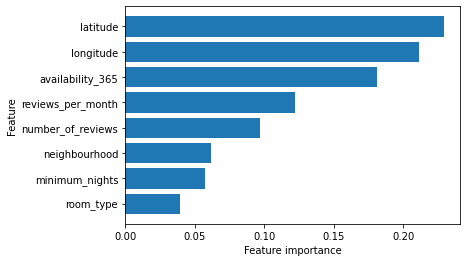

In [22]:
plot_feature_importance(df_importance)

In [51]:
pred = model.predict(X_test)

In [66]:
print(np.sqrt(mean_squared_log_error(y_test, pred)))

0.06583124328712536


#### submit

In [55]:
sub_pred = model.predict(X_inference)

In [56]:
sub_pred

array([9.5873096 , 9.44845743, 9.36531416, ..., 9.51328744, 8.13551116,
       9.13690477])

In [62]:
sample_sub[COL_Y] = np.exp(sub_pred)

In [64]:
sample_sub.to_csv('submission.csv', index=False)

In [63]:
sample_sub.head()

,id,y
0,1,14578.594504
1,2,12688.577178
2,3,11676.273525
3,4,16665.081037
4,5,15380.378399
